# Construction d'un modèle pour prédire les masques des radios

In [1]:
import numpy as np
import pandas as pd

# Gestion des fichiers/images
import os
import sys
import io
from PIL import Image, ImageFilter, ImageStat
import cv2

import matplotlib.pyplot  as plt
from matplotlib import style
from matplotlib.colors import ListedColormap
%matplotlib inline

import tensorflow as tf
from tensorflow.keras.models import Model
from tensorflow.keras.layers import *

In [2]:
# Paramètres
IMG_SHAPE = (256, 256)  # Taille des images/masques
BATCH_SIZE = 32         # Taille des batchs TensorFlow
SEED = 77               # Permet d'assurer une homogénéité dans les mélanges/transformations des datasets

In [3]:
# Définition des répertoires de données sous Colab ou en Local

# Google Colab : Permet de faire le lien avec le drive où sont stockées les images
try:
    from importlib.util import find_spec
    find_spec('google')
    from google.colab import drive
    drive.mount('/content/drive')
    os.chdir('/content/drive/MyDrive/Colab Notebooks/radio-covid19/notebooks')

    # Import des fichiers images zippés et décompression sous Colab
    # Permet d'accélérer les temps de traitements
    import zipfile
    with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/radio-covid19/data/zips/COVID.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/data/')
    with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/radio-covid19/data/zips/Viral Pneumonia.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/data/')
    with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/radio-covid19/data/zips/Normal.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/data/')
    with zipfile.ZipFile('/content/drive/MyDrive/Colab Notebooks/radio-covid19/data/zips/Lung_Opacity.zip', 'r') as zip_ref:
        zip_ref.extractall('/content/data/')
    # Chemins vers les dossiers d'images et des masks
    data_folders_path = ['/content/data/COVID/', '/content/data/Lung_Opacity/', '/content/data/Normal/', '/content/data/Viral Pneumonia/']

    # Ajoute le chemin vers le dossier des notebooks dans le PATH
    # pour pouvoir faire l'import de radiocovid.py dans Colab
    sys.path.append('/content/drive/MyDrive/Colab Notebooks/radio-covid19/notebooks')


# Exécution en local
except ImportError:
    # Chemins vers les dossiers d'images et des masks
    data_folders_path = ['../data/COVID/', '../data/Lung_Opacity/', '../data/Normal/', '../data/Viral Pneumonia/']

## Construction des jeux d'entrainement et de test

### DataFrames d'entrainement et de test

2 DataFrames seront construit :
- un jeu d'entrainement contenant les liens vers les fichiers radios et les masques associés
- un jeu de test avec les liens vers les radios et les masques associés.

In [4]:
# Initialise des listes vides pour stocker les chemins des images et des masques
input_img_paths = []
masks_img_paths = []

# Parcourt chaque dossier
for folder in data_folders_path:
    img_folder = os.path.join(folder,'images')
    masks_folder = os.path.join(folder,'masks')

    # Récupére les chemins des images
    img_paths = sorted([
        os.path.join(img_folder, fname)
        for fname in os.listdir(img_folder)
        if fname.endswith(".png")])

    # Récupére les chemins des masques
    masks_paths = sorted([
        os.path.join(masks_folder, fname)
        for fname in os.listdir(masks_folder)
        if fname.endswith(".png")])

    # Ajoute les chemins des images et des masques aux listes correspondantes
    input_img_paths.extend(img_paths)
    masks_img_paths.extend(masks_paths)

# Créé un DataFrame à partir des listes de chemins
df_all = pd.DataFrame({'image': input_img_paths, 'mask': masks_img_paths})

# Affiche un extrait du DataFrame contruit
df_all

,image,mask
0,../data/COVID/images\COVID-1.png,../data/COVID/masks\COVID-1.png
1,../data/COVID/images\COVID-10.png,../data/COVID/masks\COVID-10.png
2,../data/COVID/images\COVID-100.png,../data/COVID/masks\COVID-100.png
3,../data/COVID/images\COVID-1000.png,../data/COVID/masks\COVID-1000.png
4,../data/COVID/images\COVID-1001.png,../data/COVID/masks\COVID-1001.png
...,...,...
21160,../data/Viral Pneumonia/images\Viral Pneumonia...,../data/Viral Pneumonia/masks\Viral Pneumonia-...
21161,../data/Viral Pneumonia/images\Viral Pneumonia...,../data/Viral Pneumonia/masks\Viral Pneumonia-...
21162,../data/Viral Pneumonia/images\Viral Pneumonia...,../data/Viral Pneumonia/masks\Viral Pneumonia-...
21163,../data/Viral Pneumonia/images\Viral Pneumonia...,../data/Viral Pneumonia/masks\Viral Pneumonia-...


Le jeu de données étant volumineux, nous faisons le choix de le limiter à 6000 images.

Elles seront choisies au hasard parmi les images diponibles.

In [5]:
# Les masques sur les radios COVID sont moins bien détectés.
# Ajoute une probabilité plus grande d'avoir des images COVID dans le jeu de train/test
# (5 pour une image COVID contre 1 pour les autres)
weights = df_all['image'].str.contains('COVID') * 5 + 1

# Sélectionne 6000 images au hasard dans le DataFrame des images
df = df_all.sample(6000, random_state=SEED, weights=weights)

#séparation des jeux de données (80%,20%)
df_train = df.iloc[:-round(len(df)*0.2)]
df_test = df.iloc[-round(len(df)*0.2):]

# Prendre les tailles COVID
df_train = df.iloc[0:int(len(df)*0.8)]
df_test = df.iloc[int(len(df)*0.8):]

print("Taille du jeu d'entrainement : ", df_train.shape)
print("Taille du jeu de test", df_test.shape)

Taille du jeu d'entrainement :  (4800, 2)
Taille du jeu de test (1200, 2)


In [6]:
 print ("Ratio d'images COVID :", 100 * df_train['image'].str.contains('COVID').sum() / len(df_train['image']), "%")

Ratio d'images COVID : 46.583333333333336 %


### Pipeline de chargement des images

Comme vu à l'étape précédente, les images doivent être préprocessées. Tout le préprocessing n'est pas nécessaire, le but n'étant pas pour le moment de classifier les radios (COVID ou non-COVID).

Mais il faut a minima effectuer les tâches suivantes pour améliorer la prédiction des masques :
- redimensionnement de l'image et du masque à la même taille -> 256x256
- égalisation des histogrammes
- application du Gaussian Blur
- normalisation

Nous utiliserons la classe `TensorFlow.keras.preprocessing.image.imageDataGenerator` et sa méthode `flow_from_dataframe` qui vont nous permettre de normaliser les images, et de les redimensionner. De plus, `imageDataGenerator` permet de définir une fonction de pre-processing (`preprocessing_function`) que nous allons utiliser pour appliquer nos transformations qui ne peuvent être faites à l'aide des fonctions/couches existantes dans `TensorFlow` ou `Keras`.

**Fonction de preprocessing**

In [10]:
import cv2

def preprocess(img):
    """Preprocessing des images
    """

    # Change le type des données pour qu'il soit compatible avec cv2
    # Sauvegarde du type reçu
    saved_dtype = img.dtype
    # Change en entier 8 bits non signé
    img = img.astype('uint8')
    #-- img=cv2.cvtColor(img, cv2.COLOR_RGB2GRAY)

    # Egalisation
    img=cv2.equalizeHist(img)

    # Gaussian Blur
    img=cv2.GaussianBlur(img, ksize=(5,5), sigmaX=0)

    # Rétablit le format de l'image d'origine
    #-- img=cv2.cvtColor(img, cv2.COLOR_GRAY2RGB)

    img = img.astype(saved_dtype)
    img = img.reshape((256,256,1))  #--

    return (img)

**Définition des datasets**

In [8]:
# Jeu d'entrainement

train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess, rescale=1./255).flow_from_dataframe(df_train,
                                                                                                              x_col='image',
                                                                                                              target_size=IMG_SHAPE,
                                                                                                              batch_size=BATCH_SIZE,
                                                                                                              seed=SEED,
                                                                                                              color_mode='grayscale',
                                                                                                              class_mode=None)

train_mask_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_dataframe(df_train,
                                                                                                           x_col='mask',
                                                                                                           target_size=IMG_SHAPE,
                                                                                                           batch_size=BATCH_SIZE,
                                                                                                           seed=SEED,
                                                                                                           color_mode='grayscale',
                                                                                                           class_mode=None)

train = zip(train_image_generator, train_mask_generator)

Found 4800 validated image filenames.
Found 4800 validated image filenames.


In [9]:
test_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess, rescale=1./255).flow_from_dataframe(df_test,
                                                                                                           x_col='image',
                                                                                                           target_size=IMG_SHAPE,
                                                                                                           batch_size=BATCH_SIZE,
                                                                                                           seed=SEED,
                                                                                                           color_mode='grayscale',
                                                                                                           class_mode=None,
                                                                                                           shuffle=False)


test_mask_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_dataframe(df_test,
                                                                                                          x_col='mask',
                                                                                                          target_size=IMG_SHAPE,
                                                                                                          batch_size=BATCH_SIZE,
                                                                                                          seed=SEED,
                                                                                                          color_mode='grayscale',
                                                                                                          class_mode=None,
                                                                                                          shuffle=False)

test = zip(test_image_generator, test_mask_generator)

Found 1200 validated image filenames.
Found 1200 validated image filenames.


## Construction d'un modèle U-NET

Nous utilisons un modèle de type U-Net pour déterminer les masques des images.

In [10]:
inputs = Input(shape=(IMG_SHAPE[0],IMG_SHAPE[1], 1))

# Convolutions

conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(inputs)     # IMG : 256,256  -> 256,256
conv1 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv1)      # IMG : 256,256  -> 256,256
pool1 = MaxPooling2D()(conv1)                                                                        # IMG : 256,256  -> 128,128

conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool1)      # IMG : 128,128  -> 128,128
conv2 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv2)      # IMG : 128,128  -> 128,128
pool2 = MaxPooling2D()(conv2)                                                                        # IMG : 128,128  ->  64, 64

conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool2)     # IMG : 64² -> 64²
conv3 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv3)     # IMG : 64² -> 64²
pool3 = MaxPooling2D()(conv3)                                                                        # IMG : 64² -> 32²

conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool3)     # IMG : 32² -> 32²
conv4 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv4)     # IMG : 32² -> 32²
drop4 = Dropout(0.3)(conv4)
pool4 = MaxPooling2D()(drop4)                                                                        # IMG : 32² -> 16²

conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(pool4)     # IMG : 16² -> 16²
conv5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv5)     # IMG : 16² -> 16²
drop5 = Dropout(0.3)(conv5)


# ---

drop5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop5)     # IMG : 16² -> 16²
drop5 = Conv2D(256, 3, activation='relu', padding='same', kernel_initializer='he_normal')(drop5)     # IMG : 16² -> 16²

# ---

# Dé-Convolutions

up6 = UpSampling2D((2,2))(drop5)                                                                     # up6   : 16²    -> 32²
merge6 = concatenate([up6, conv4], axis=3)
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge6)    # conv6 : 32² -> 32²
conv6 = Conv2D(128, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv6)     # conv6 : 32² -> 32²

up7 = UpSampling2D((2,2))(conv6)                                                                     # conv6 : 32² -> 64²
merge7 = concatenate([up7, conv3], axis=3)
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge7)    # conv7 : 64² -> 64²
conv7 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv7)     # conv7 : 64² -> 64²

up8 = UpSampling2D((2,2))(conv7)                                                                     # up8  :  64² -> 128²
merge8 = concatenate([up8, conv2], axis=3)
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge8)     # conv8 : 128² -> 128²
conv8 = Conv2D(32, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv8)      # conv8 : 128² -> 128²

up9 = UpSampling2D((2,2))(conv8)                                                                     # up9   : 128²  -> 256²
merge9 = concatenate([up9, conv1], axis=3)
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(merge9)     # conv9 : 256² -> 256²
conv9 = Conv2D(16, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)      # conv9 : 256² -> 256²

conv9 = Conv2D(64, 3, activation='relu', padding='same', kernel_initializer='he_normal')(conv9)      # conv9 : 256² -> 256²

conv9 = Conv2D(1, 1, activation ='sigmoid')(conv9)                                                 # conv9 : 256² -> 256²


model = Model(inputs = inputs, outputs = conv9, name='UNet')
model.summary()

Model: "UNet"
__________________________________________________________________________________________________
 Layer (type)                Output Shape                 Param #   Connected to                  
 input_1 (InputLayer)        [(None, 256, 256, 1)]        0         []                            
                                                                                                  
 conv2d (Conv2D)             (None, 256, 256, 16)         160       ['input_1[0][0]']             
                                                                                                  
 conv2d_1 (Conv2D)           (None, 256, 256, 16)         2320      ['conv2d[0][0]']              
                                                                                                  
 max_pooling2d (MaxPooling2  (None, 128, 128, 16)         0         ['conv2d_1[0][0]']            
 D)                                                                                            

### Entraînement

In [13]:
# Utilise une fonction de callback qui va permettre de stoppe l'entraînement
# si la courbe d'apprentissage n'évolue plus
callback = tf.keras.callbacks.EarlyStopping(monitor='loss', min_delta=0.002, patience=3, verbose=0)

In [14]:
model.compile(optimizer='adam',
              loss="binary_crossentropy",
              metrics=['accuracy', tf.keras.metrics.BinaryIoU()])

In [15]:
# Sauvegarde le poids des couches du modèles avant entraînement
# Utilisé dans le paragraphe : Recherche de la dimension optimum du jeu d'entraînement
model.save_weights('../data/models/cache/initial_weights')

In [16]:
hist = model.fit(train,
                 epochs=16,
                 batch_size=BATCH_SIZE,
                 steps_per_epoch=(len(df_train)//BATCH_SIZE),
                 validation_data=test,
                 validation_batch_size=BATCH_SIZE,
                 validation_steps=len(df_test)//BATCH_SIZE,
                 callbacks=[callback]
                 )

Epoch 1/16
150/150 [==============================] - 100s 495ms/step - loss: 0.2729 - accuracy: 0.9173 - binary_io_u: 0.7947 - val_loss: 0.1245 - val_accuracy: 0.9491 - val_binary_io_u: 0.8624
Epoch 2/16
150/150 [==============================] - 76s 510ms/step - loss: 0.0775 - accuracy: 0.9700 - binary_io_u: 0.9215 - val_loss: 0.0632 - val_accuracy: 0.9751 - val_binary_io_u: 0.9329
Epoch 3/16
150/150 [==============================] - 73s 487ms/step - loss: 0.0584 - accuracy: 0.9771 - binary_io_u: 0.9394 - val_loss: 0.0496 - val_accuracy: 0.9802 - val_binary_io_u: 0.9462
Epoch 4/16
150/150 [==============================] - 78s 523ms/step - loss: 0.0476 - accuracy: 0.9810 - binary_io_u: 0.9495 - val_loss: 0.0518 - val_accuracy: 0.9790 - val_binary_io_u: 0.9428
Epoch 5/16
150/150 [==============================] - 78s 522ms/step - loss: 0.0430 - accuracy: 0.9827 - binary_io_u: 0.9540 - val_loss: 0.0404 - val_accuracy: 0.9837 - val_binary_io_u: 0.9557
Epoch 6/16
150/150 [==============

### Evaluation

Au bout de 16 epochs, l'accuracy sur le jeu de validation est de 97.11% avec avec un perte (binary_crossentropy) de 0.0220.

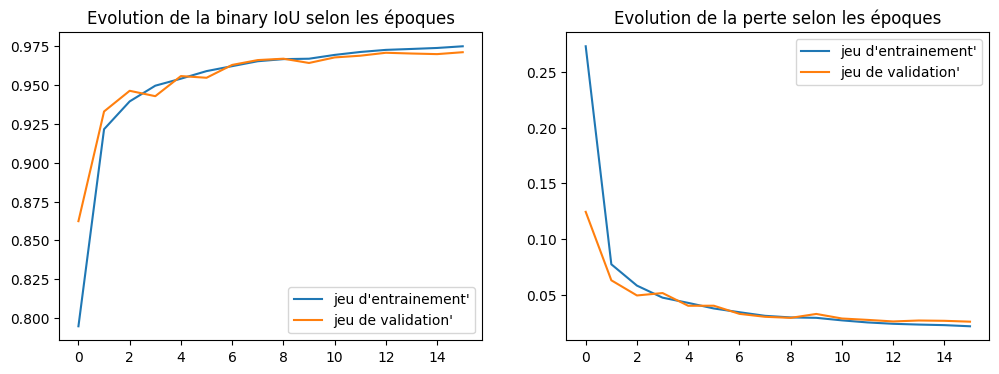

In [17]:
plt.figure(figsize=(12,4))

plt.subplot(1,2,1, title="Evolution de la binary IoU selon les époques")
plt.plot(hist.history['binary_io_u'],  label="jeu d'entrainement'")
plt.plot(hist.history['val_binary_io_u'],  label="jeu de validation'")
plt.legend()

plt.subplot(1,2,2, title="Evolution de la perte selon les époques")
plt.plot(hist.history['loss'],  label="jeu d'entrainement'")
plt.plot(hist.history['val_loss'],  label="jeu de validation'")
plt.legend()

plt.show()

### Sauvegarde du modèle

Le modèle est sauvegardé pour pouvoir être réutilisé ultérieurement.

In [21]:
# Sauvegarde du modèle entraîné
model.save('../data/models/mask_detection_20240130')

In [6]:
# Chargement du modèle
model = tf.keras.models.load_model('../data/models/mask_detection_20240130')

In [81]:
img = cv2.imread('../streamlit_app/assets/classification_masquage_2.png', cv2.IMREAD_GRAYSCALE)
img = cv2.resize(img, (256, 256))
img = preprocess(img)

In [84]:
img = img.reshape(1, 256, 256, 1)

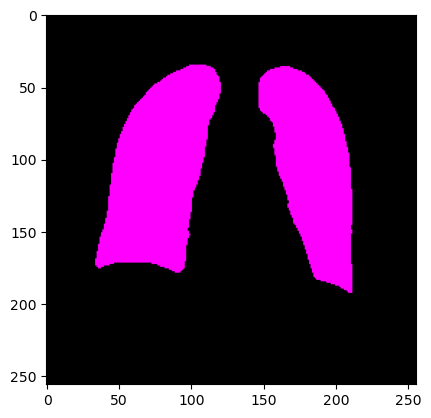

In [85]:
plt.imshow(np.stack((msk.squeeze(),np.zeros((256, 256)),msk.squeeze()), axis=2))

In [87]:
msk = model(img)
msk = tf.squeeze(msk).numpy().reshape((256, 256))
msk_rgb = np.stack((np.zeros((256, 256)), msk, msk), axis=2)



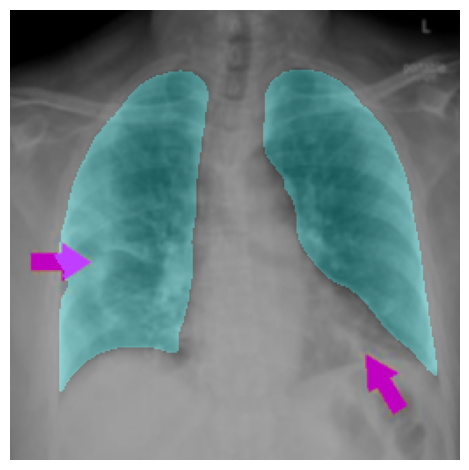

In [90]:
plt.imshow(cv2.resize(cv2.imread('../streamlit_app/assets/classification_masquage_2.png'), (256, 256)))
msk_3coul = [msk], [0], [msk]
plt.axis('off')
plt.imshow(msk_rgb, alpha=0.25)

plt.tight_layout()
plt.savefig('../streamlit_app/assets/classification_masquage_2_mask.png', bbox_inches='tight')

In [13]:
# Calcul des prédictions du jeu de test
y_preds = model.predict(test, batch_size=BATCH_SIZE, steps=37)

37/37 [==============================] - 167s 4s/step


In [ ]:
# Récupération des valeurs réelles des images
#from tqdm import tqdm
#y_true = None
#batches = 0
#test_mask_generator.reset()
#for (masks) in tqdm(test_mask_generator, desc='Lecture des masques ', total=(test_mask_generator.n // BATCH_SIZE)-1):
    #batches += 1
    #if y_true is None:
        #y_true = masks.copy()
   # else:
        #y_true = np.concatenate((y_true, masks.copy()), axis=0)
    #if batches >= test_mask_generator.n // BATCH_SIZE :
        # Termine la boucle manuellement,
        # ImageDataGenerator boucle indéfiniement
        #break

Lecture des masques : 100%|██████████| 36/36 [00:03<00:00,  9.37it/s]


In [ ]:
#y_preds_thresh = tf.cast(y_preds>=0.5, tf.float32)

In [ ]:
#Calcul de la matrice de confusion
#pd.crosstab(y_true.flatten(),y_preds_thresh.numpy().flatten(),normalize=True)

### Affichage de prédictions

Les prédiction faites par le modèle sont complétées d'un seuillage pour permettre d'avoir un masque 'binaire' (0 ou 255).

1/1 [==============================] - 4s 4s/step


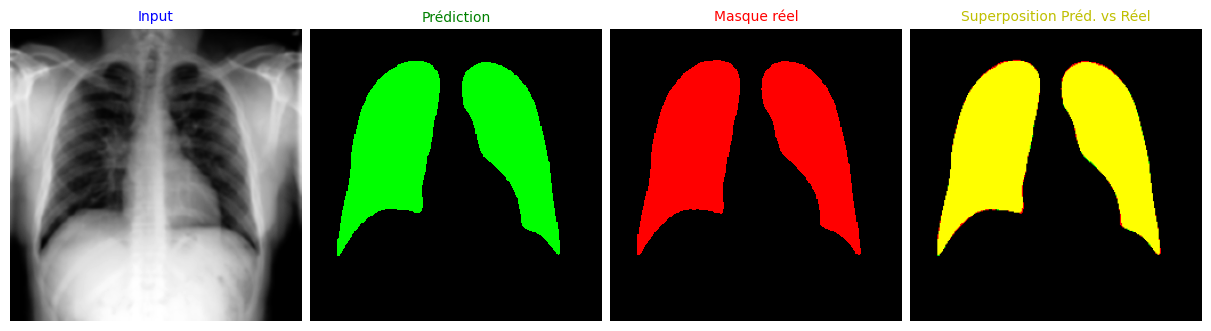

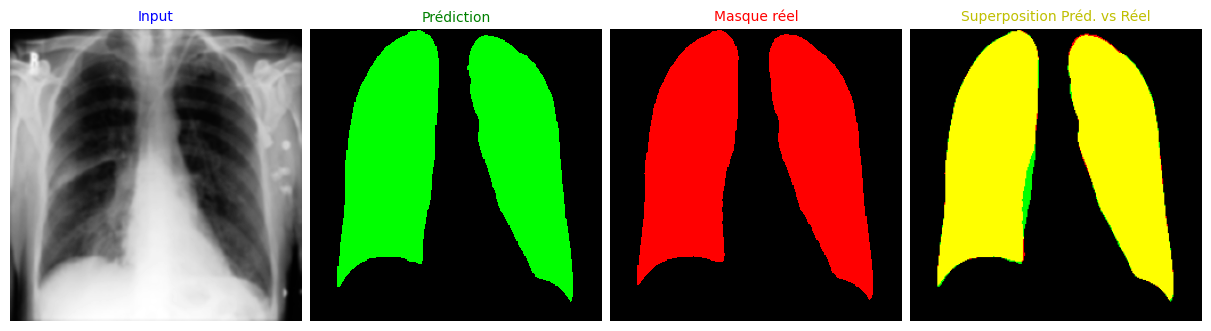

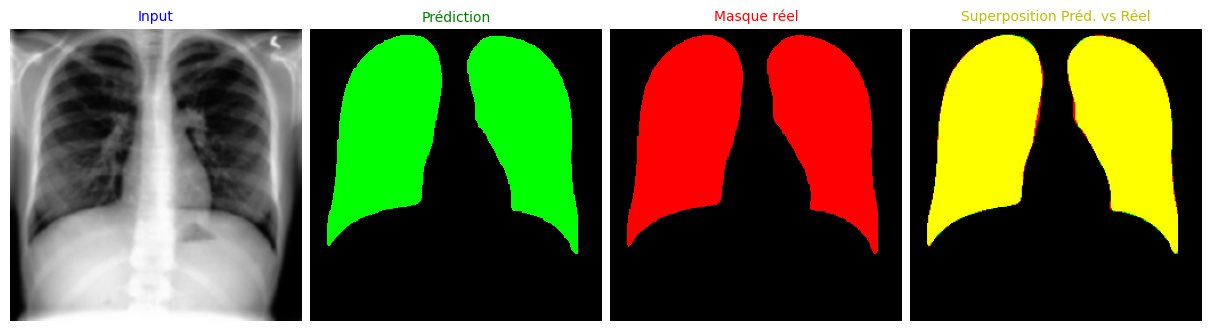

In [97]:
# Affiche quelques prédictions

# Sélectionne le premier batch du jeu de test
# Rappel : le batch est sous la forme (images, masks)
(img, msk) = test.__next__()

# Lance la prédiction du batch sélectionné
pred_mask  = model.predict(img)

# Affiche les prédictions faites sur le batch testé

# Pour chaque élément du batch
# Limite à 8 images pour éviter de surcharger l'écran inutilement

nb_cas  = min(pred_mask.shape[0], 3)
for i in range(0, nb_cas):

    plt.figure(figsize=(12,6), layout='compressed')
    plt.set_cmap('gray')

    plt.subplot(1, 4, 1)
    plt.title('Input', color='b', fontsize='medium')
    plt.axis('off')
    plt.imshow(img[i])

    #plt.subplot(1, 4, 2)
    #plt.title('Prédiction', color='g', fontsize='medium')
    #plt.axis('off')
    #plt.imshow(pred_mask[i])

    plt.subplot(1, 4, 2)
    plt.title('Prédiction', color='g', fontsize='medium')
    plt.axis('off')
    _, img_thresh = cv2.threshold(255*(pred_mask[i].reshape(256,256)), 127, 255, cv2.THRESH_BINARY)
    plt.imshow(img_thresh, cmap=ListedColormap(['#000000','#00FF00']))

    plt.subplot(1, 4, 3)
    plt.title('Masque réel', color='r', fontsize='medium')
    plt.axis('off')
    plt.imshow(msk[i], cmap=ListedColormap(['#000000','#FF0000']))

    plt.subplot(1, 4, 4)
    plt.title('Superposition Préd. vs Réel', color='y', fontsize='medium')
    # image prédite dans la couche de vert
    v = np.uint8(img_thresh.reshape(256,256,1))
    # la couche bleue n'est pas utilisée
    b = np.zeros((256,256,1), dtype='uint8')
    # image rélle dans la couche de rouge
    r = np.uint8(255*msk[i])
    # Image finale = superposition des 3 couches (en lumière : vert + rouge = jaune)
    rvb = np.concatenate([r,v,b], axis=-1)
    plt.axis('off')
    plt.imshow(rvb)

    plt.show()

# Rercherche du nombre idéal d'images pour calculer le masque

Pour rechercher le nombre idéal d'images d'entraînement, nous allons itérativement :
- sélectionner un dataset d'images de plus en plus important
- calculer le modèle de prédiction du masque des radios pour chaque dataset
- évaluer l'accuracy sur le même dataset de test (un échantillon de 1200 images) pour que le résultat soit comparable.

In [24]:
# train_sizes = np.linspace(32, 10000, num=10, endpoint=True, dtype='int')
train_sizes = [32, 64, 128, 256, 512, 1024, 2496, 4992, 9984]
hists = {}

In [25]:
# Récupère un jeu d'images pour le jeu de test
df_test = df_all.sample(1200, random_state=SEED)

# Pour chaque taille de jeu d'entraînement
for train_size in train_sizes:
    # Détermine un jeu d'images pour le jeu d'entraînement
    # en retirant les images déjà prises par le jeu de test.
    # Les images pourront être sélectionnées plusieurs fois pour correspondre au nombre d'images souhaité
    df_train = df_all[~df_all.index.isin(df_test.index)].sample(train_size, replace=True, random_state=SEED)

    print ("Taille du jeu d'entraînement :", len(df_train))


    # Création du dataset train
    train_image_generator = tf.keras.preprocessing.image.ImageDataGenerator(preprocessing_function=preprocess, rescale=1./255).flow_from_dataframe(df_train,
                                                                                                                  x_col='image',
                                                                                                                  target_size=IMG_SHAPE,
                                                                                                                  batch_size=BATCH_SIZE,
                                                                                                                  seed=SEED,
                                                                                                                  color_mode='grayscale',
                                                                                                                  class_mode=None)
    train_mask_generator = tf.keras.preprocessing.image.ImageDataGenerator(rescale=1./255).flow_from_dataframe(df_train,
                                                                                                               x_col='mask',
                                                                                                               target_size=IMG_SHAPE,
                                                                                                               batch_size=BATCH_SIZE,
                                                                                                               seed=SEED,
                                                                                                               color_mode='grayscale',
                                                                                                               class_mode=None)
    train = zip(train_image_generator, train_mask_generator)


    # Réutilisation du modèle créé plus haut
    # Réinitialisation des poids du modèle
    model.compile(optimizer='adam', loss="binary_crossentropy", metrics=['accuracy', tf.keras.metrics.BinaryIoU()])
    model.load_weights('../data/models/cache/initial_weights')

    # Recalcule les poids du modèle
    hists[train_size] = model.fit(train,
                                  epochs=16,
                                  batch_size=BATCH_SIZE,
                                  steps_per_epoch=(len(df_train)//BATCH_SIZE),
                                  validation_data=test,
                                  validation_batch_size=BATCH_SIZE,
                                  validation_steps=len(df_test)//BATCH_SIZE,
                                  callbacks=[callback],
                                  verbose=1)

Taille du jeu d'entraînement : 32
Found 32 validated image filenames.
Found 32 validated image filenames.
Epoch 1/16
1/1 [==============================] - 13s 13s/step - loss: 0.5877 - accuracy: 0.7328 - binary_io_u_1: 0.3904 - val_loss: 8.1236 - val_accuracy: 0.7630 - val_binary_io_u_1: 0.3815
Epoch 2/16
1/1 [==============================] - 6s 6s/step - loss: 12.1168 - accuracy: 0.7572 - binary_io_u_1: 0.3786 - val_loss: 0.6132 - val_accuracy: 0.7628 - val_binary_io_u_1: 0.3814
Epoch 3/16
1/1 [==============================] - 8s 8s/step - loss: 0.6906 - accuracy: 0.7569 - binary_io_u_1: 0.3784 - val_loss: 0.4984 - val_accuracy: 0.7549 - val_binary_io_u_1: 0.3778
Epoch 4/16
1/1 [==============================] - 5s 5s/step - loss: 0.5188 - accuracy: 0.7461 - binary_io_u_1: 0.3730 - val_loss: 0.5041 - val_accuracy: 0.7546 - val_binary_io_u_1: 0.3780
Epoch 5/16
1/1 [==============================] - 11s 11s/step - loss: 0.5222 - accuracy: 0.7467 - binary_io_u_1: 0.3734 - val_loss: 0.

In [26]:
import pickle

In [32]:
# Sauvegarde de l'history pour pouvoir le réutiliser dans une prochaine session
fic = open('../data/hists.zip', 'wb')
pickle.dump(hists, fic)
fic.close()

In [57]:
# Lecture de l'history sauvegardé
fic = open('../data/hists.zip', 'rb')
hists = pickle.load(fic)
fic.close()

In [58]:
print(hists[h].history.keys())


dict_keys(['loss', 'accuracy', 'binary_io_u_1', 'val_loss', 'val_accuracy', 'val_binary_io_u_1'])


In [59]:
iou  = []
loss = []
bin_iou_num = 1

for h in hists:
    iou.append(hists[h].history['val_binary_io_u_'+str(bin_iou_num)][-1])
    loss.append(hists[h].history['val_loss'][-1])
    bin_iou_num +=1

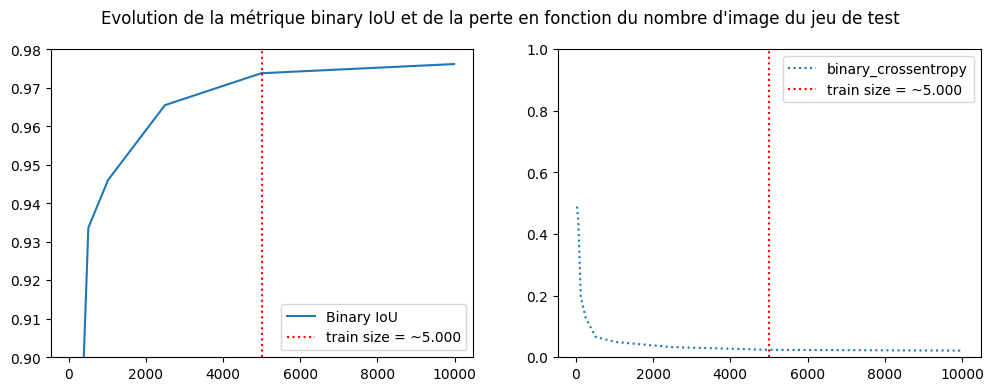

In [60]:
plt.figure(figsize=(12,4))
plt.suptitle("Evolution de la métrique binary IoU et de la perte en fonction du nombre d'image du jeu de test")


plt.subplot(121)
plt.plot(train_sizes, iou, label='Binary IoU')
plt.ylim((0.90, 0.98))
plt.vlines(5000, 0.90, 0.98, color='red', linestyle=':', label='train size = ~5.000')
plt.legend()

plt.subplot(122)
plt.plot(train_sizes, loss, label='binary_crossentropy', linestyle=':')
plt.ylim((0., 1.))
plt.vlines(5000, 0, 1., color='red', linestyle=':', label='train size = ~5.000')
plt.legend()

plt.show()

Pour un entraînement optimum, l'échantillon doit comporter environ 5.000 images.